# Introduction

Hi Kagglers,

This is a supplementary notebook to the Kiva Data Science for Good challenge. The results of this notebook are used in the [Kiva Philippines Poverty Score notebook](https://www.kaggle.com/rossrco/kiva-philippines-poverty-score).

In this notebook, we'll clean up the data from the Philippine Statistics Authority. The data is based on the triennial Family Income and Expenditure Survey. We'll use this data to find income predictors. This in turn will allow us to derive a poverty score for the instances of Kiva loans in the Philippines.

# Data Transformation Description

To transform the data, we'll perform a standard set of operations on the columns of the original dataset. These operations are namely:

1. Mapping the column values to query-friendly names. We'll define query friendly names as lowercase, underscore-separated names that utilize abbreviation wherever possible. This allows us to one hot encode columns that are concise in name length and easier for referring to in Pandas dataframe internal queries (e.g. `dataframe[dataframe.column_1 < 5]`).
2. One hot encoding column values.
3. Merging several columns into one. We'll perform such operations where several columns have similar semantic and consist exclusively of numeric values. Example: the columns `number_mobile_phones` and `number_landline_phones` can be combined into a `number_communication_devices = number_mobile_phones + number_landline_phones`
4. Reducing column values. We'll perform such operations where many values can be arranged in few classes while still preserving the meaning of the data. Example: the `household_head_education` column could have values for each grade of each school type completed plus the various university degrees one could attain. We could reduce these values to: elementary, primary, secondary and tertiary education.
5. Renaming columns to give them query friendly-names.

# Special Considerations

The `household head occupations` column more difficult to handle since it has more than 300 distict values. Our intuition is that in the context of poverty assessment, the farming professions would be meaningful. The rationale behind that is that farmers are usually the most isolated and poor individuals, especially in developing countries. We'll use a simple regular expression to derive the farming professions and map them to a `house_head_farmer_flag`.

We'll create a separate `num_comm_devices` from the `num_electronic_devices` because lack of communication could indicate poverty (especially financial exclusion). This could be valuable for the Kiva personnel in the field.

In [2]:
#numeric
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from IPython.display import display

plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.titlepad'] = 25
sns.set_color_codes('pastel')

#Pandas warnings
import warnings
warnings.filterwarnings('ignore')

#system
import os
import re

In [3]:
#import the FIES data set
phil_inc = pd.read_csv('Family Income and Expenditure.csv')

#define standard naming convention for the regions in the Philippines
region_mapping_phil_inc = {'CAR' : 'car',\
                           'Caraga' : 'caraga',\
                           'VI - Western Visayas' : 'western visayas',\
                           'V - Bicol Region' : 'bicol',\
                           ' ARMM' : 'armm',\
                           'III - Central Luzon' : 'central luzon',\
                           'II - Cagayan Valley' : 'cagayan valley',\
                           'IVA - CALABARZON' : 'calabarzon',\
                           'VII - Central Visayas' : 'central visayas',\
                           'X - Northern Mindanao' : 'northern mindanao',\
                           'XI - Davao Region' : 'davao',\
                           'VIII - Eastern Visayas' : 'eastern visayas',\
                           'I - Ilocos Region' : 'ilocos',\
                           'NCR' : 'ncr',\
                           'IVB - MIMAROPA' : 'mimaropa',\
                           'XII - SOCCSKSARGEN' : 'soccsksargen',\
                           'IX - Zasmboanga Peninsula' : 'zamboanga'}

#map the region values in the FIES data set to the standard naming convention
phil_inc.Region = phil_inc.Region.map(region_mapping_phil_inc)

#map the main source of income categories to query-friendly values
phil_inc['Main Source of Income'] = phil_inc['Main Source of Income']\
.map({'Wage/Salaries' : 'main_inc_wage',\
      'Other sources of Income' : 'main_inc_other',\
      'Enterpreneurial Activities' : 'main_inc_entrepreneur'})

#one hot encode the main source of income categories
phil_inc_extract = phil_inc.join(pd.get_dummies(phil_inc['Main Source of Income']))

#remove specific food expense columns
phil_inc_extract.drop(['Main Source of Income', 'Bread and Cereals Expenditure',\
                       'Total Rice Expenditure', 'Meat Expenditure',\
                       'Total Fish and  marine products Expenditure',\
                       'Fruit Expenditure', 'Vegetables Expenditure'],\
                      axis = 1,\
                      inplace = True)

#sum the non-essential expense columns into a single feature
phil_inc_extract['non_essential_expenses'] = phil_inc_extract['Restaurant and hotels Expenditure'] +\
                                             phil_inc_extract['Alcoholic Beverages Expenditure'] +\
                                             phil_inc_extract['Tobacco Expenditure']

#remove the non-essential expense columns
phil_inc_extract.drop(['Restaurant and hotels Expenditure',\
                       'Alcoholic Beverages Expenditure',\
                       'Tobacco Expenditure'],\
                      axis = 1,\
                      inplace = True)

#one hot encode the household head sex
phil_inc_extract['Household Head Sex'] = phil_inc_extract['Household Head Sex']\
.map({'Female' : 1,\
      'Male' : 0})

#rename the household head sex column to query-friendly name
phil_inc_extract.rename(columns = {'Household Head Sex' : 'house_head_sex_f'}, inplace = True)

#define civil statuses that correspond to single / no partner
single_civil_statuses = ['Single', 'Widowed', 'Divorced/Separated', 'Annulled', 'Unknown']

#group the civil statuses into single and partner
phil_inc_extract['Household Head Marital Status'] = ['house_head_single'\
                                                     if s in single_civil_statuses\
                                                     else 'house_head_partner'\
                                                     for s\
                                                     in phil_inc_extract['Household Head Marital Status']]

#one hot encode the single / partner categories
phil_inc_extract = phil_inc_extract.join(pd.get_dummies(phil_inc_extract['Household Head Marital Status']))

#remove the marital status column
phil_inc_extract.drop(['Household Head Marital Status'],\
                      axis = 1,\
                      inplace = True)

#group the education categories into illiterate, primary_ed and secondary_ed - tertiary_ed is implicit
illiterate = ['No Grade Completed', 'Preschool']
primary_ed = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5', 'Grade 6', 'Elementary Graduate']
secondary_ed = ['First Year High School', 'Second Year High School', 'Third Year High School', 'High School Graduate']

def get_education_level(ed_string):
    if ed_string in illiterate:
        return 'house_head_illiterate'
    elif ed_string in primary_ed:
        return 'house_head_primary_ed'
    elif ed_string in secondary_ed:
        return 'house_head_secondary_ed'
    else:
        return 'house_head_tertiary_ed'

#map the education categories to the grouped values
phil_inc_extract['Household Head Highest Grade Completed'] = [get_education_level(e)\
                                                              for e\
                                                              in phil_inc_extract['Household Head Highest Grade Completed']]

#one hot encode the education groups
phil_inc_extract = phil_inc_extract.join(pd.get_dummies(phil_inc_extract['Household Head Highest Grade Completed']))

#remove the household head education column
phil_inc_extract.drop(['Household Head Highest Grade Completed'],\
                      axis = 1,\
                      inplace = True)

#rename and one hot encode the household head job column
phil_inc_extract.rename(columns = {'Household Head Job or Business Indicator' : 'house_head_empl'}, inplace = True)
phil_inc_extract.house_head_empl = phil_inc_extract.house_head_empl.map({'With Job/Business' : 1,\
                                                                         'No Job/Business' : 0})

#fill the missing values from the household head occupation column in preparation for the regex
phil_inc_extract['Household Head Occupation'].fillna('', inplace = True)

#record all unique occupations
unque_occupations = phil_inc_extract['Household Head Occupation'].unique().tolist()

#create a regular expression that detects all job types that contain the word 'farm'
farmer_flag = re.compile(r'farm', re.I)

#derive a flag from the 'farmer' regex from all unique occupations
phil_inc_extract['house_head_farmer'] = [1 if re.findall(farmer_flag, w) else 0 for w in phil_inc_extract['Household Head Occupation']]

#remove the household head occupation and class of worker columns
phil_inc_extract.drop(['Household Head Occupation', 'Household Head Class of Worker'], axis = 1, inplace = True)

#give the type of household column categories query-friendly names
phil_inc_extract['Type of Household'] = phil_inc_extract['Type of Household']\
.map({'Extended Family' : 'house_ext_family',
      'Single Family' : 'house_singl_family',
      'Two or More Nonrelated Persons/Members' : 'house_mult_family'})

#one hot encode the type of household categories
phil_inc_extract = phil_inc_extract.join(pd.get_dummies(phil_inc_extract['Type of Household']))

#remove the type of household column
phil_inc_extract.drop(['Type of Household'], axis = 1, inplace = True)

#rename the family member columns to query-friendly names
phil_inc_extract.rename(columns = {'Total Number of Family members' : 'num_family_members',
                                   'Members with age less than 5 year old' : 'num_children_younger_5',
                                   'Members with age 5 - 17 years old' : 'num_children_older_5',
                                   'Total number of family members employed' : 'num_family_members_employed'},
                        inplace = True)

#give the type of building column categories query-friendly names
phil_inc_extract['Type of Building/House'] = phil_inc_extract['Type of Building/House']\
.map({'Single house' : 'house',
      'Duplex' : 'duplex',
      'Commercial/industrial/agricultural building' : 'living_at_workplace',
      'Multi-unit residential' : 'residential_block',
      'Institutional living quarter' : 'institutional_housing',
      'Other building unit (e.g. cave, boat)' : 'other_housing'})

#one hot encode the type of building categories
phil_inc_extract = phil_inc_extract.join(pd.get_dummies(phil_inc_extract['Type of Building/House']))

#remove the type of building column
phil_inc_extract.drop(['Type of Building/House'], axis = 1, inplace = True)

#give the type of roof column categories query-friendly names
phil_inc_extract['Type of Roof'] = phil_inc_extract['Type of Roof']\
.map({'Strong material(galvanized,iron,al,tile,concrete,brick,stone,asbestos)' : 'roof_material_strong',
      'Light material (cogon,nipa,anahaw)' : 'roof_material_light',
      'Mixed but predominantly strong materials' : 'roof_material_mostly_strong',
      'Mixed but predominantly light materials' : 'roof_material_mostly_light',
      'Salvaged/makeshift materials' : 'roof_material_makeshift',
      'Mixed but predominantly salvaged materials' : 'roof_material_mostly_makeshift',
      'Not Applicable' : 'no_roof'})

#one hot encode the type of roof categories
phil_inc_extract = phil_inc_extract.join(pd.get_dummies(phil_inc_extract['Type of Roof']))

#remove the type of roof column
phil_inc_extract.drop(['Type of Roof'], axis = 1, inplace = True)

#give the type of walls column categories query-friendly names
phil_inc_extract['Type of Walls'] = phil_inc_extract['Type of Walls']\
.map({'Strong' : 'wall_material_strong',
      'Light' : 'wall_material_light',
      'Quite Strong' : 'wall_material_quite_strong',
      'Very Light' : 'wall_material_quite_light',
      'Salvaged' : 'wall_material_salvaged',
      'NOt applicable' : 'no_walls'})

#one hot encode the type of walls categories
phil_inc_extract = phil_inc_extract.join(pd.get_dummies(phil_inc_extract['Type of Walls']))

#remove the type of walls column
phil_inc_extract.drop(['Type of Walls'], axis = 1, inplace = True)

#rename house type columns to query-friendly names
phil_inc_extract.rename(columns = {'House Floor Area' : 'house_area',
                                   'House Age' : 'house_age',
                                   'Number of bedrooms' : 'num_bedrooms'},
                        inplace = True)

#give the toilet facilities column categories query-friendly names
phil_inc_extract['Toilet Facilities'] = phil_inc_extract['Toilet Facilities']\
.map({'Water-sealed, sewer septic tank, used exclusively by household' : 'ws_septic_toiled',
      'Water-sealed, sewer septic tank, shared with other household' : 'ws_septic_toiled',
      'Closed pit' : 'septic_toiled',
      'Water-sealed, other depository, used exclusively by household' : 'ws_other_toilet',
      'Open pit' : 'septic_toiled',
      'Water-sealed, other depository, shared with other household' : 'ws_other_toilet',
      'None' : 'no_toilet',
      'Others' : 'other_toilet'})

#one hot encode the toilet facilities categories
phil_inc_extract = phil_inc_extract.join(pd.get_dummies(phil_inc_extract['Toilet Facilities']))

#remove the toilet facilities and tenure status columns
phil_inc_extract.drop(['Toilet Facilities', 'Tenure Status'], axis = 1, inplace = True)

#define category groups that correspond to running water / no running water
running_water = ['Own use, faucet, community water system', 'Shared, faucet, community water system']

#derive the running water flag
phil_inc_extract['running_water'] = [1 if i in running_water else 0 for i in phil_inc_extract['Main Source of Water Supply']]

#remove the main source of water supply columns
phil_inc_extract.drop(['Main Source of Water Supply'], axis = 1, inplace = True)

#sum the various electronic device counts into a single feature
phil_inc_extract['num_electronics'] = phil_inc_extract['Number of Television'] +\
phil_inc_extract['Number of CD/VCD/DVD'] +\
phil_inc_extract['Number of Component/Stereo set'] +\
phil_inc_extract['Number of Personal Computer']

#remove the specific columns for various electronic devices
phil_inc_extract.drop(['Number of Television',\
                       'Number of CD/VCD/DVD',\
                       'Number of Component/Stereo set',\
                       'Number of Personal Computer'],\
                      axis = 1,\
                      inplace = True)

#sum the communication devices columns into a single feature
phil_inc_extract['num_comm_devices'] = phil_inc_extract['Number of Landline/wireless telephones'] +\
phil_inc_extract['Number of Cellular phone']

#remove the individual communication devices columns
phil_inc_extract.drop(['Number of Landline/wireless telephones',\
                       'Number of Cellular phone'],\
                      axis = 1,\
                      inplace = True)

#sum the various vehicle counts into a single feature
phil_inc_extract['num_vehicles'] = phil_inc_extract['Number of Car, Jeep, Van'] +\
phil_inc_extract['Number of Motorized Banca'] +\
phil_inc_extract['Number of Motorcycle/Tricycle']

#remove the individual vehicle columns
phil_inc_extract.drop(['Number of Car, Jeep, Van',\
                       'Number of Motorized Banca',\
                       'Number of Motorcycle/Tricycle'],\
                      axis = 1,\
                      inplace = True)

#rename the rest of the columns to query-friendly names
phil_inc_extract.rename(columns = {'Total Household Income' : 'household_income',
                                   'Region' : 'region',
                                   'Total Food Expenditure' : 'food_expenses',
                                   'Agricultural Household indicator' : 'agricultural_household',
                                   'Clothing, Footwear and Other Wear Expenditure' : 'clothing_expenses',
                                   'Housing and water Expenditure' : 'house_and_water_expenses',
                                   'Imputed House Rental Value' : 'house_rental_value',
                                   'Medical Care Expenditure' : 'medical_expenses',
                                   'Transportation Expenditure' : 'transport_expenses',
                                   'Communication Expenditure' : 'comm_expenses',
                                   'Education Expenditure' : 'education_expenses',
                                   'Miscellaneous Goods and Services Expenditure' : 'misc_expenses',
                                   'Special Occasions Expenditure' : 'special_occasion_expenses',
                                   'Crop Farming and Gardening expenses' : 'farming_gardening_expenses',
                                   'Total Income from Entrepreneurial Acitivites' : 'income_from_entrepreneur_activities',
                                   'Household Head Age' : 'house_head_age',
                                   'Electricity' : 'electricity',
                                   'Number of Refrigerator/Freezer' : 'num_refrigerator',
                                   'Number of Washing Machine' : 'num_wash_machine',
                                   'Number of Airconditioner' : 'num_ac',
                                   'Number of Stove with Oven/Gas Range' : 'num_stove'},
                        inplace = True)


# Data Export

We have now transformed all columns in the FIES dataset. A row from the resulting dataset looks like this:

In [4]:
phil_inc_extract.loc[0]

household_income                       480332
region                                    car
food_expenses                          117848
agricultural_household                      0
clothing_expenses                        4607
house_and_water_expenses                63636
house_rental_value                      30000
medical_expenses                         3457
transport_expenses                       4776
comm_expenses                            2880
education_expenses                      36200
misc_expenses                           34056
special_occasion_expenses                7200
farming_gardening_expenses              19370
income_from_entrepreneur_activities     44370
house_head_sex_f                            1
house_head_age                             49
house_head_empl                             1
num_family_members                          4
num_children_younger_5                      0
num_children_older_5                        1
num_family_members_employed       

At this point we can save our transformed file and re-use it in the [main notebook](https://www.kaggle.com/rossrco/kiva-philippines-poverty-score).

In [5]:
phil_inc_extract.to_csv('philippines_census_data_cl.csv')

# Data Visualization

With the modified data set saved, we can now add a few data visualizations. Those can help us get an overall understanding of the data set's usefulness.

We will start by deriving an estimated family employment feature. It will be defined as: number of employed family members / (total number family members - children). We will also derive `no_electricity` and `no_running_water` indicators.

Let's now plot the estimated family employment by region:

In [6]:
phil_inc_extract['est_family_employment'] = [fam_mem_empl / (fam_mem - child_younger_5 - child_older_5)\
                                             if (fam_mem - child_younger_5 - child_older_5) != 0\
                                             else 0\
                                             for fam_mem_empl, fam_mem, child_younger_5, child_older_5\
                                             in zip(phil_inc_extract.num_family_members_employed,\
                                                    phil_inc_extract.num_family_members,\
                                                    phil_inc_extract.num_children_younger_5,\
                                                    phil_inc_extract.num_children_older_5)]

phil_inc_extract['no_electricity'] = 1 - phil_inc_extract.electricity
phil_inc_extract['no_running_water'] = 1 - phil_inc_extract.running_water

In [7]:
phil_inc_grouped_r_s = phil_inc_extract.groupby(by = ['region', 'house_head_sex_f']).mean().reset_index()
phil_inc_grouped_r = phil_inc_extract.groupby(by = ['region']).mean().reset_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

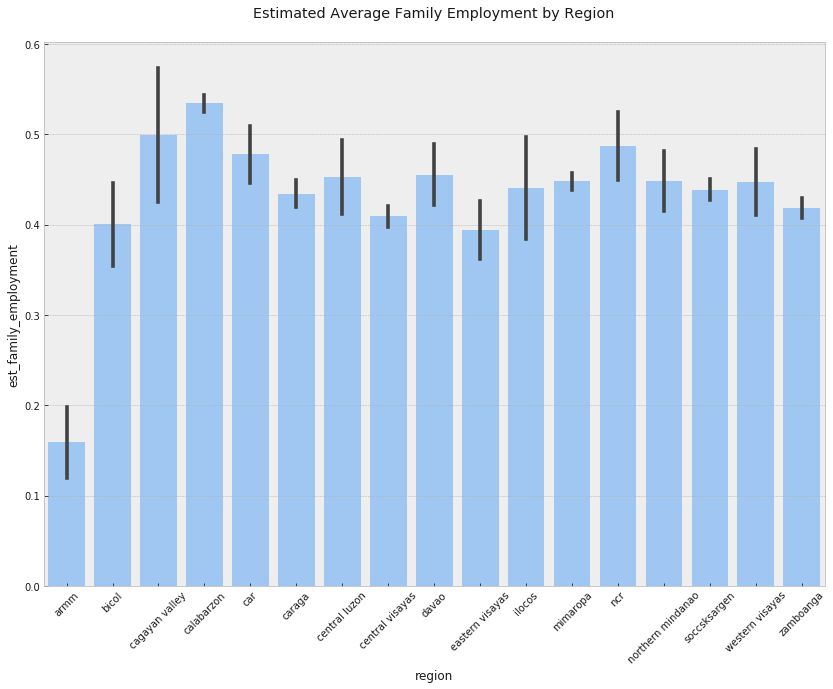

In [8]:
sns.barplot(x = 'region', y = 'est_family_employment', data = phil_inc_grouped_r_s, color = 'b')
plt.title('Estimated Average Family Employment by Region')
plt.xticks(rotation = 45)

We can see from the very beginning that the Autonomous Region of Muslim Mindanao (ARMM) is severely affected by unemployment. Another notable feature is that in the Cagayan Valley the disparity in employment between households with male and female heads is greatest.

We continue by visualizing the three major poverty indicators (no running water, no toilet and no electricity):

Text(0.5,1,'Various Poverty Indicators by Region')

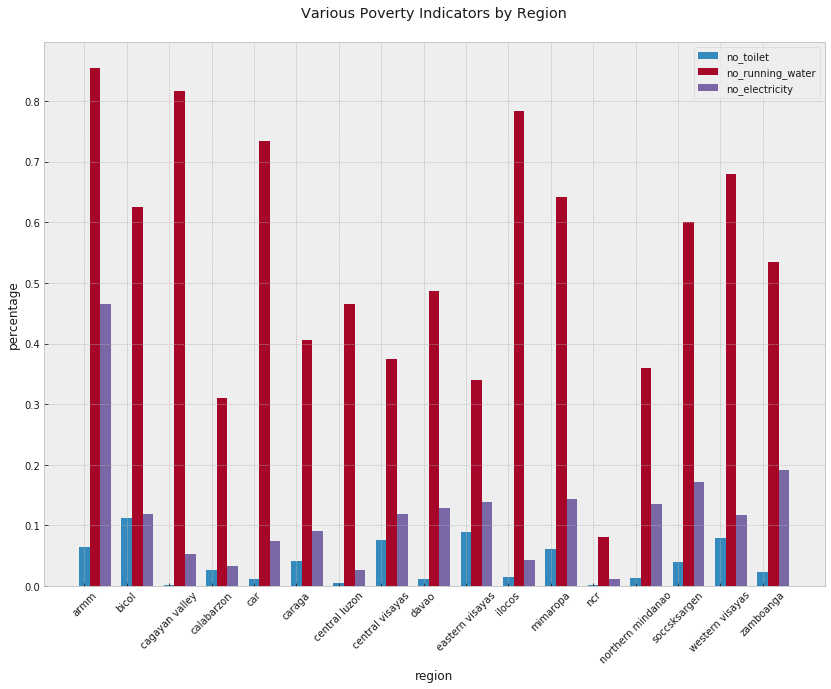

In [9]:
x_ticks = np.arange(len(phil_inc_grouped_r.region))
plt.xticks(x_ticks, phil_inc_grouped_r.region, rotation = 45)
for f, i in zip(('no_toilet', 'no_running_water', 'no_electricity'), (0, 1, 2)):
    plt.bar(x_ticks + (0.25 * i), phil_inc_grouped_r[f], align = 'center', label = f, width = 0.25)
plt.legend()
plt.xlabel('region')
plt.ylabel('percentage')
plt.title('Various Poverty Indicators by Region')

Again ARMM is severely affected as measured by all three indicators. We could expect that incomes in that province would be the lowest for the country. Let's confirm that:

Text(0.5,1,'Household Income by Region')

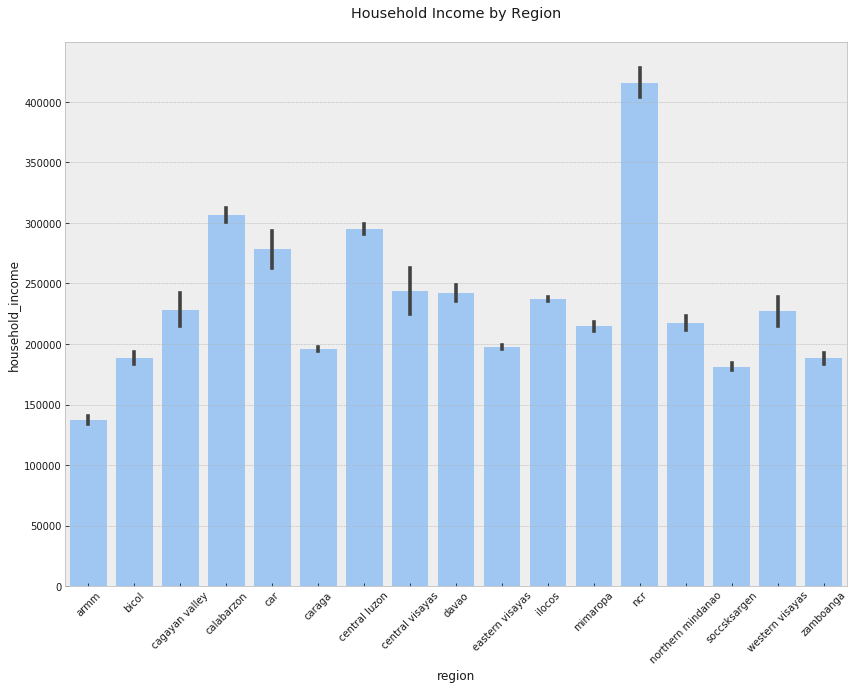

In [10]:
sns.barplot(x = 'region', y = 'household_income', data = phil_inc_grouped_r_s, color = 'b')
plt.xticks(rotation = 45)
plt.title('Household Income by Region')

The income distribution by region fits our expectations. Another observation (for the sake of sense-checking the data) is that the National Capital Region (NCR) has the highest average income. This is also in line with expectations.

Let's now turn to more general data patterns and investigate for useful predictors of income. We will start by comparing the distributions of food expenses and household income:

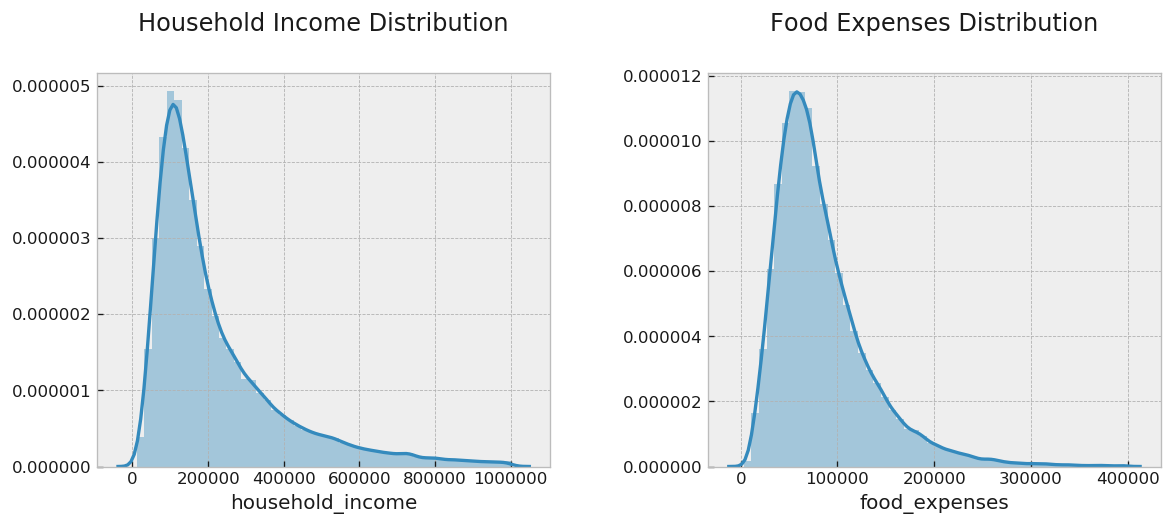

In [11]:
fig = plt.figure(figsize = (18, 10), dpi = 120)
fig.subplots_adjust(hspace = 0.3, wspace = 0.35)

ax1 = fig.add_subplot(2, 3, 1)
ax1.set_title('Household Income Distribution')
sns.distplot(phil_inc_extract.household_income[phil_inc_extract.household_income < 1000000])

ax2 = fig.add_subplot(2, 3, 2)
ax2.set_title('Food Expenses Distribution')
sns.distplot(phil_inc_extract.food_expenses[phil_inc_extract.food_expenses < 400000])

Apparently, the distributions are quite similar (both are positively skewed). We can visually inspect the correlation between the two variables in the next scatterplot:

Text(0.5,1,'Household Income by Food Expenses')

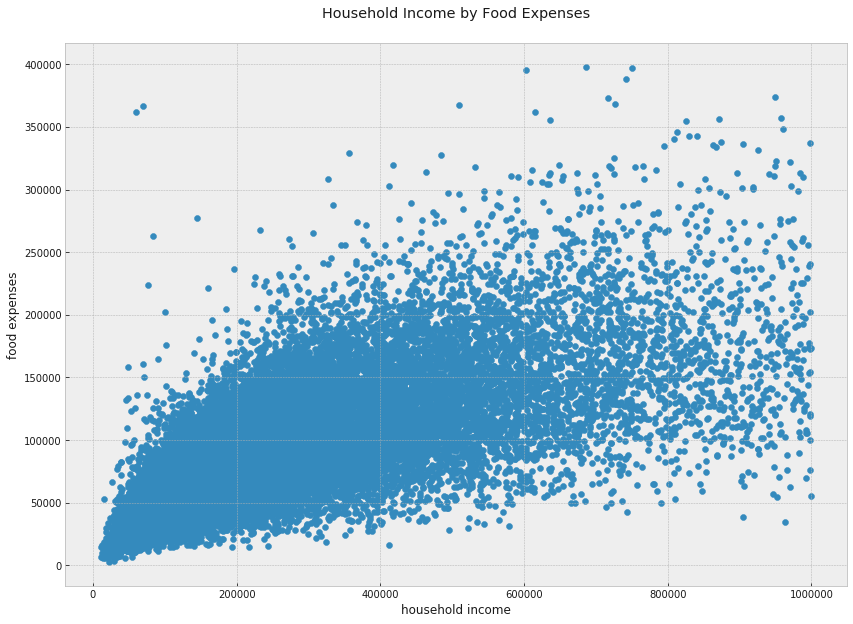

In [12]:
plt.scatter(phil_inc_extract.household_income[\
                                              (phil_inc_extract.household_income < 1000000) &\
                                              (phil_inc_extract.food_expenses < 400000)],\
            phil_inc_extract.food_expenses[\
                                              (phil_inc_extract.household_income < 1000000) &\
                                              (phil_inc_extract.food_expenses < 400000)])

plt.xlabel('household income')
plt.ylabel('food expenses')
plt.title('Household Income by Food Expenses')

There is an apparent correlation between household income and food expenses.

Finally, we could expect that lack of communication means lack of access to the economy of the country. Let's investigate the relationship between the number of communication devices and household income in the next plot:

Text(0.5,1,'Household Income by Number of Communication Devices')

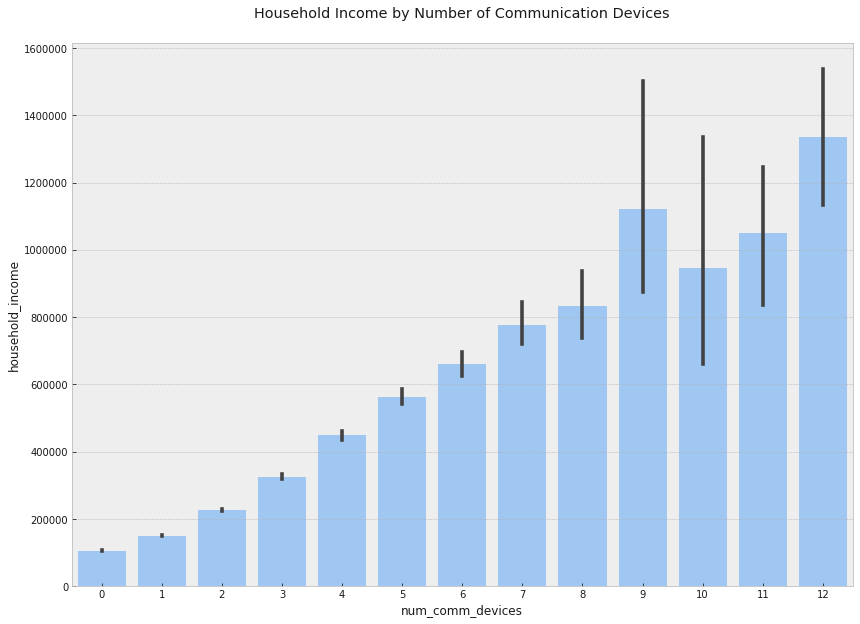

In [13]:
sns.barplot(x = 'num_comm_devices', y = 'household_income', data = phil_inc_extract, color = 'b')
plt.title('Household Income by Number of Communication Devices')

As we expected, access to communication correlates highly with the household income.

In [14]:
num_col = ['clothing_expenses', 'house_and_water_expenses',
           'house_rental_value', 'medical_expenses', 'transport_expenses', 'comm_expenses',
           'education_expenses', 'misc_expenses', 'special_occasion_expenses',
           'farming_gardening_expenses']

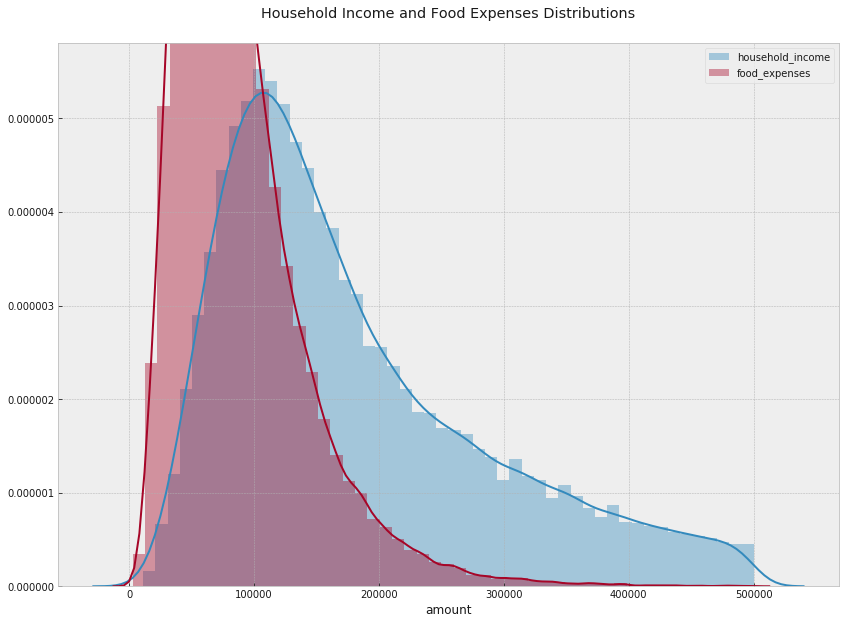

In [15]:
for c in ['household_income', 'food_expenses']:
    sns.distplot(phil_inc_extract[phil_inc_extract[c] < 500000][c], label = c)

plt.xlabel('amount')
plt.title('Household Income and Food Expenses Distributions')
plt.legend()

In [18]:
for c in ['household_income', 'food_expenses']:
    display(phil_inc_extract[c].describe())

count    4.154400e+04
mean     2.475556e+05
std      2.868805e+05
min      1.128500e+04
25%      1.048950e+05
50%      1.640795e+05
75%      2.911385e+05
max      1.181599e+07
Name: household_income, dtype: float64

count     41544.000000
mean      85099.158194
std       51637.947682
min        2947.000000
25%       51017.250000
50%       72985.500000
75%      105635.500000
max      827565.000000
Name: food_expenses, dtype: float64

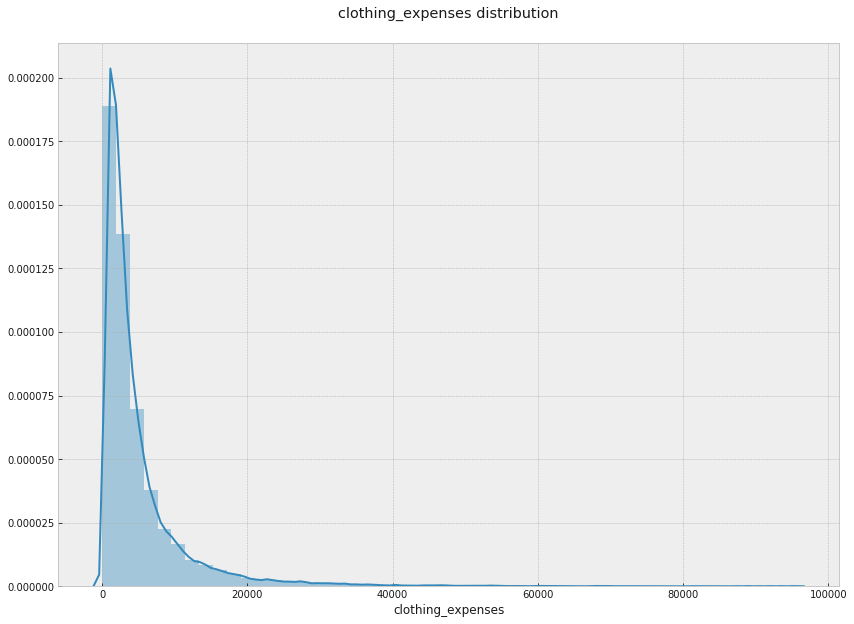

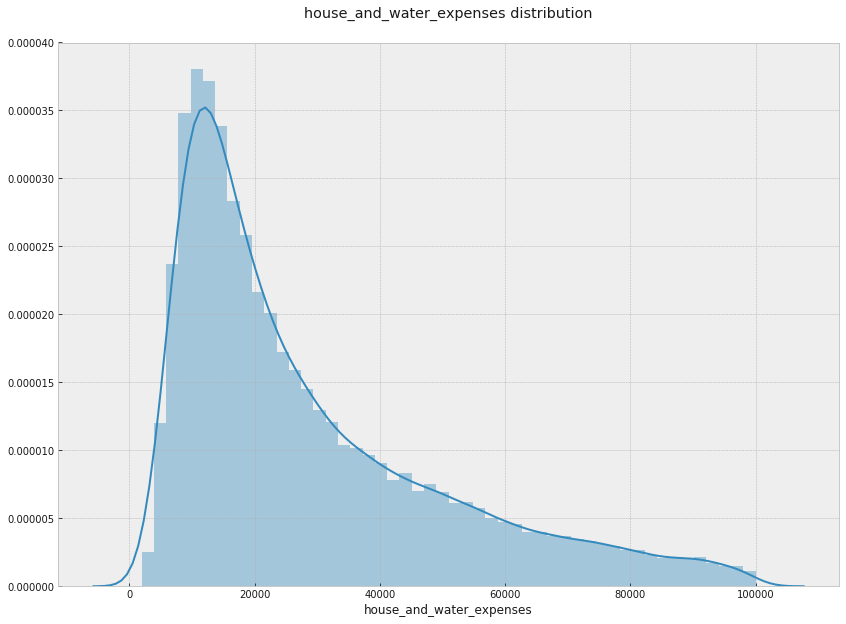

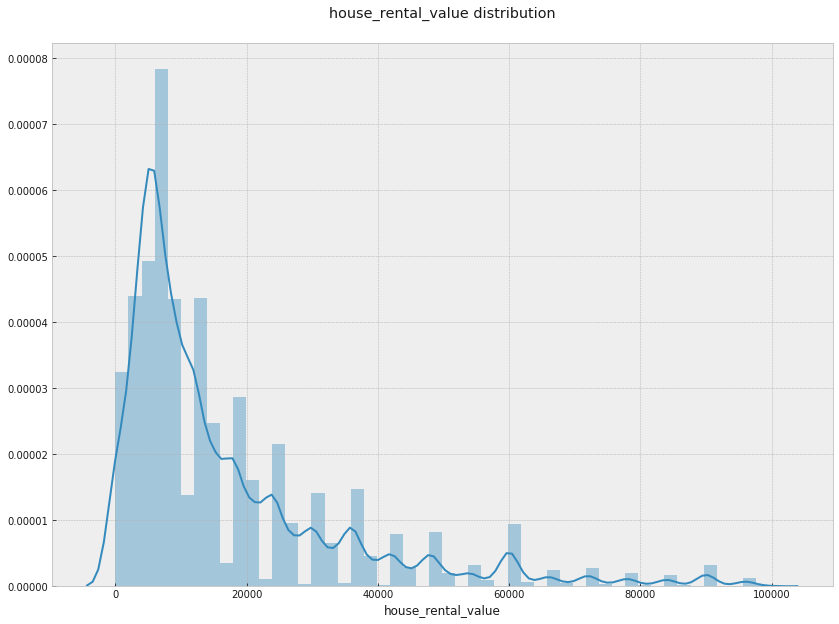

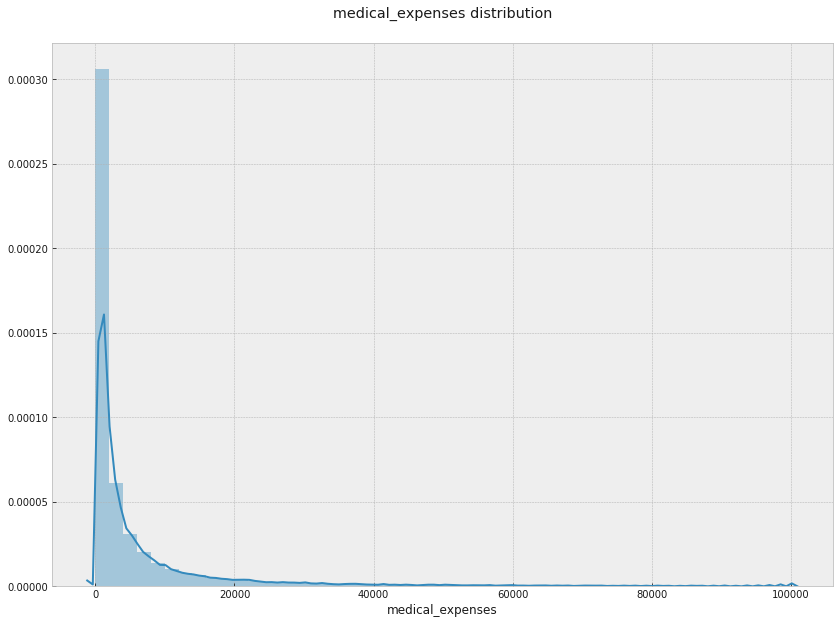

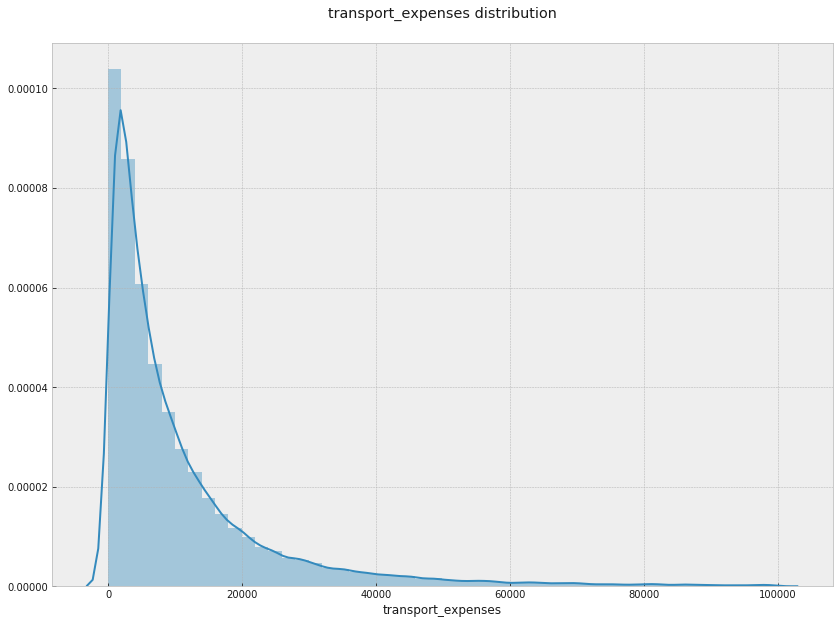

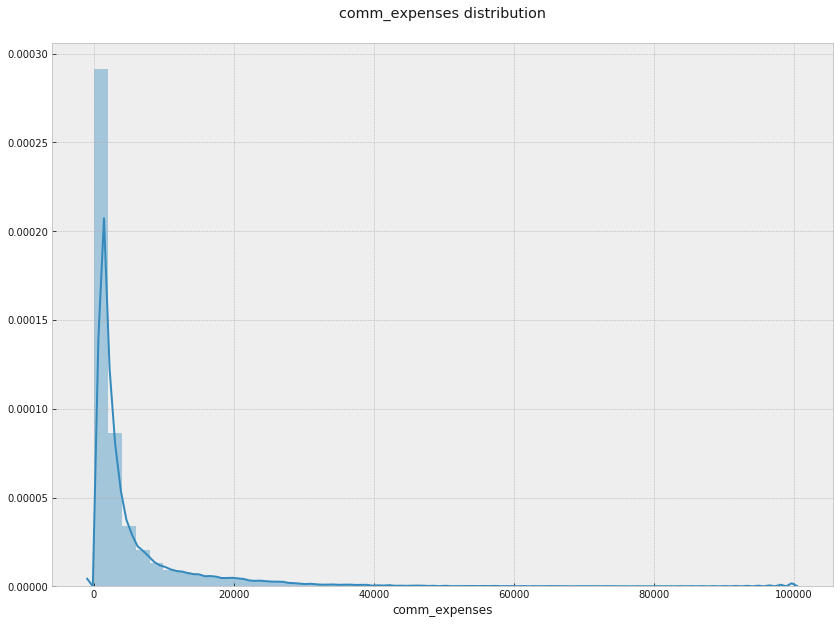

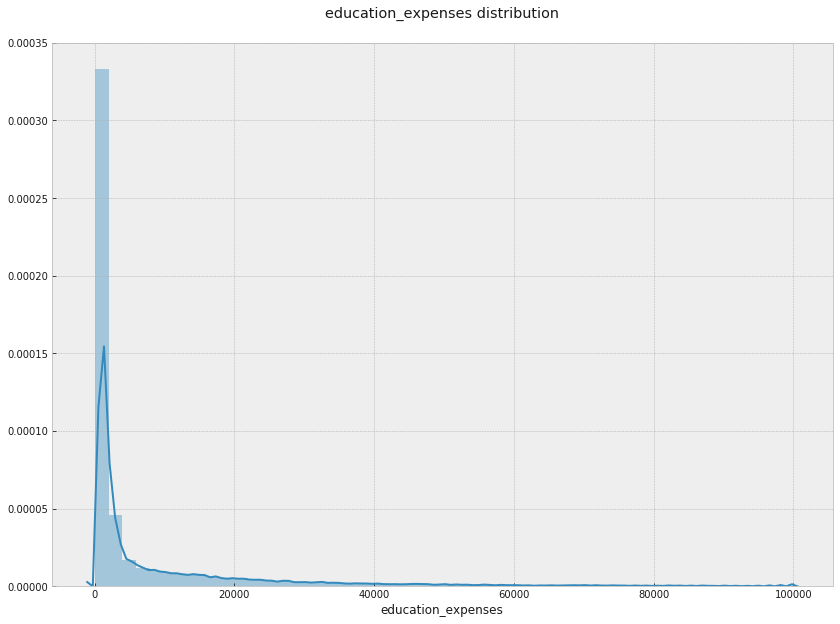

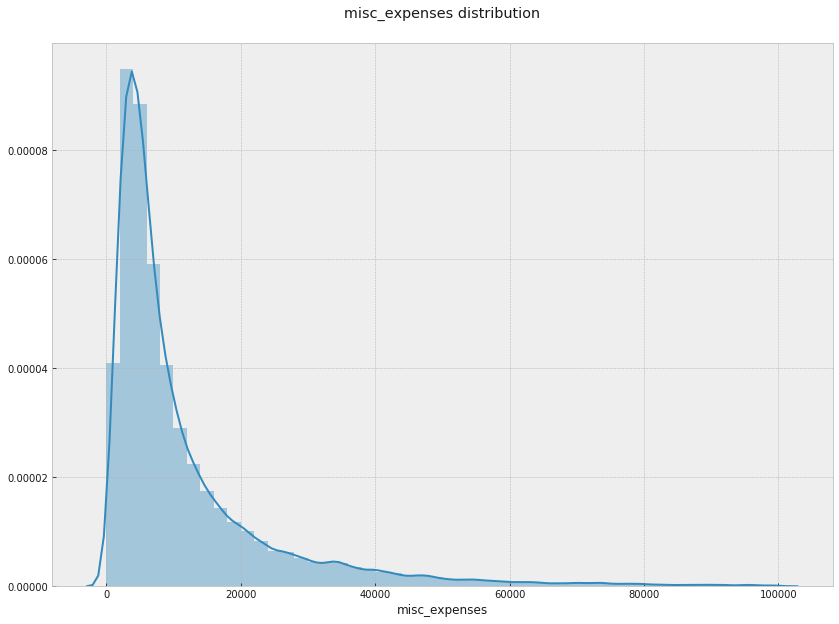

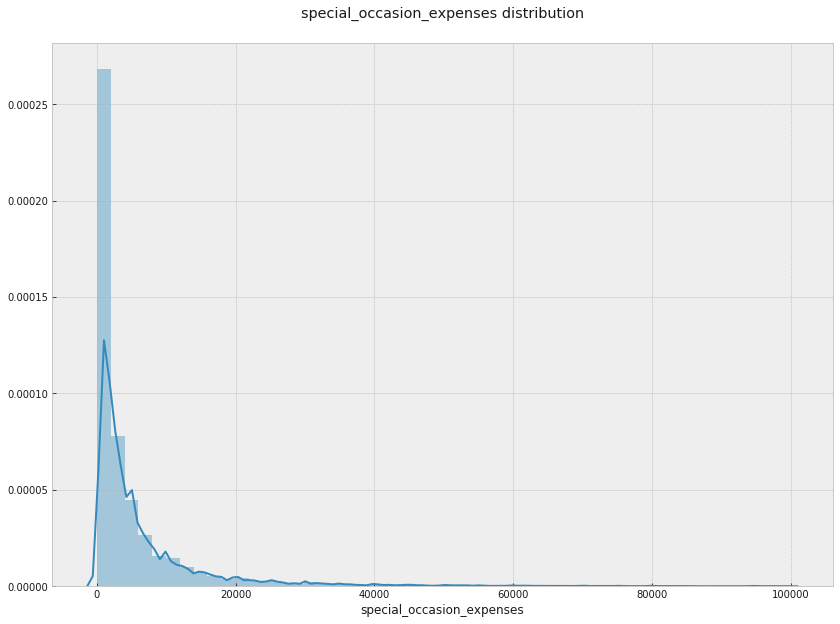

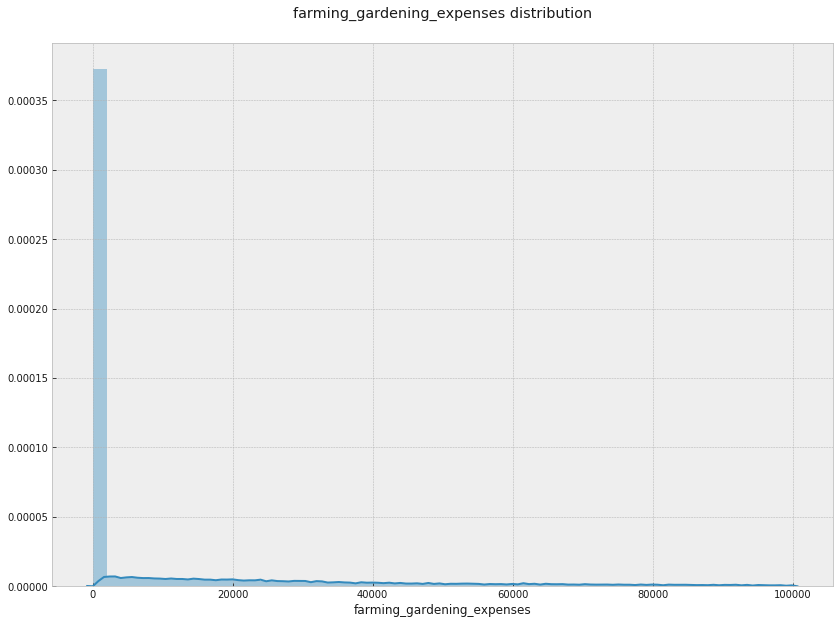

In [17]:
for c in num_col:
    plt.title('%s distribution' % c)
    plt.show(sns.distplot(phil_inc_extract[phil_inc_extract[c] < 100000][c], label = c))

We can now conclude that our dataset is indeed useful for the purposes of predicting the household income and return to the [main notebook](https://www.kaggle.com/rossrco/kiva-philippines-poverty-score).